In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Datasets

In [2]:
def load_data_arrays():
    df_1 = pd.read_csv("../../datasets/1_preprocessed.csv")
    df_3 = pd.read_csv("../../datasets/3_preprocessed.csv")
    df_5 = pd.read_csv("../../datasets/5_preprocessed.csv")
    df_6 = pd.read_csv("../../datasets/6_preprocessed.csv")
    
    df = df_1.append(df_3)
    df = df.append(df_5)
    df = df.append(df_6)
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

train_df, test_df = load_data_arrays()


# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Keywords feature

In [3]:
df_kw = pd.read_csv("../../datasets/bad_words.csv")
kw_vocab = set()
for idx, item in df_kw.iterrows():
  kw_vocab.add(item[0])
kw_vocab_len = len(kw_vocab) + 1
kw_layer = tf.keras.layers.TextVectorization(vocabulary=list(kw_vocab))
kw_layer.compile()

### Encoder feature

In [4]:
VOCAB_SIZE = 2000
ec_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
ec_layer.adapt(train_dataset.map(lambda text, label: text))

### Model

In [5]:
import tensorflow.keras.layers as layers

input_layer = layers.Input(shape=(1,), dtype=(tf.string))
seq_layer = kw_layer(input_layer)
seq_layer = layers.Embedding(input_dim=len(kw_layer.get_vocabulary()), output_dim=64, mask_zero=True)(seq_layer)
seq_layer = layers.Bidirectional(tf.keras.layers.LSTM(64))(seq_layer)
seq_layer = layers.Dense(64, activation='relu')(seq_layer)
seq_layer = layers.Dense(2, activation='softmax')(seq_layer)
seq2_layer = ec_layer(input_layer)
seq2_layer = layers.Embedding(input_dim=len(ec_layer.get_vocabulary()), output_dim=64, mask_zero=True)(seq2_layer)
seq2_layer = layers.Bidirectional(tf.keras.layers.LSTM(64))(seq2_layer)
seq2_layer = layers.Dense(64, activation='relu')(seq2_layer)
seq2_layer = layers.Dense(2, activation='softmax')(seq2_layer)
concat_layer = layers.Concatenate(axis=1)([seq_layer, seq2_layer])
output_layer = layers.Dense(2, activation='softmax')(concat_layer)

model = tf.keras.Model(name="hatespeech_detector", inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset, validation_steps=10)

Epoch 1/5
2717/2717 [==============================] - 614s 221ms/step - loss: 0.6049 - accuracy: 0.7447 - val_loss: 0.4837 - val_accuracy: 0.9172
Epoch 2/5
2717/2717 [==============================] - 622s 229ms/step - loss: 0.4019 - accuracy: 0.9344 - val_loss: 0.3640 - val_accuracy: 0.9172
Epoch 3/5
2717/2717 [==============================] - 624s 230ms/step - loss: 0.3020 - accuracy: 0.9290 - val_loss: 0.2969 - val_accuracy: 0.9141
Epoch 4/5
2717/2717 [==============================] - 540s 199ms/step - loss: 0.2496 - accuracy: 0.9243 - val_loss: 0.2894 - val_accuracy: 0.8750
Epoch 5/5
2717/2717 [==============================] - 534s 197ms/step - loss: 0.2161 - accuracy: 0.9269 - val_loss: 0.2299 - val_accuracy: 0.9172


In [12]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

680/680 [==============================] - 58s 67ms/step - loss: 0.2101 - accuracy: 0.9274
Test Loss: 0.21008461713790894
Test Accuracy: 0.9273601770401001


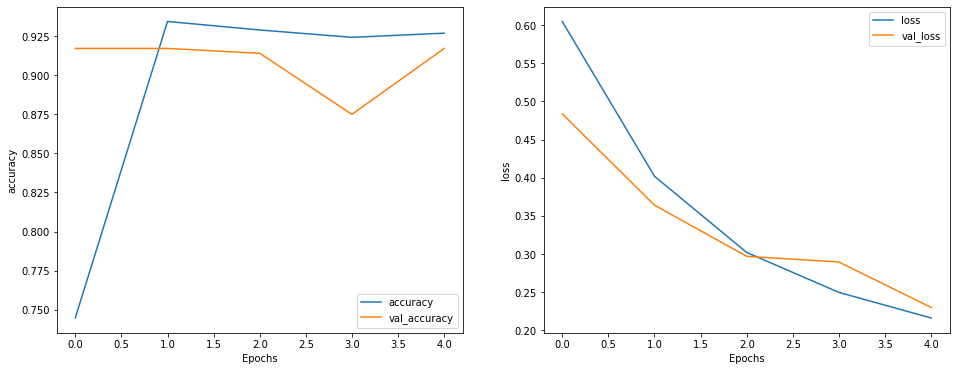

In [7]:
np.set_printoptions(precision=3, suppress=True)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

               precision    recall  f1-score   support

no hatespeech       0.92      0.99      0.95     31026
   hatespeech       0.96      0.78      0.86     12435

     accuracy                           0.93     43461
    macro avg       0.94      0.88      0.91     43461
 weighted avg       0.93      0.93      0.93     43461



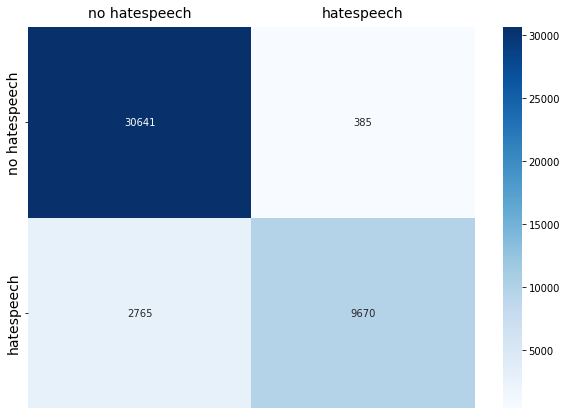

In [8]:
from sklearn.metrics import classification_report
import seaborn as sn

pred = model.predict(test_dataset)
test_data_labels = np.concatenate([y for x, y in test_dataset], axis=0)

print(classification_report(test_data_labels.argmax(axis=1),
                            pred.argmax(axis=1),
                            target_names=['no hatespeech', 'hatespeech']))

def plot_confusion_matrix(labels, pred, index, columns):
    conf = tf.math.confusion_matrix(labels=[np.argmax(val) for val in labels],
                                    predictions=[np.argmax(val) for val in pred])

    df_cm = pd.DataFrame(conf.numpy(), index=index, columns=columns)

    plt.figure(figsize=(10, 7))
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom=False, top=False,
                    labeltop=True)
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()

plot_confusion_matrix(labels=test_data_labels,
                      pred=pred,
                      index=['no hatespeech', 'hatespeech'],
                      columns=['no hatespeech', 'hatespeech'])

In [9]:
sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.01  0.99 ]
 [0.995 0.005]]


In [10]:
model.save('saves/binary_features')

INFO:tensorflow:Assets written to: saves/binary_features\assets


INFO:tensorflow:Assets written to: saves/binary_features\assets
